# Density-Based Spatial Clustering of Applications with Noise from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
    - [Key Concepts](#key-concepts)
    - [Steps](#steps)
2. [Loading Data](#2-loading-data)
3. [Selecting Optimal Parameters](#3-selecting-optimal-parameters)
4. [Identifying Core Points](#4-identifying-core-points)
5. [Cluster Formation](#5-cluster-formation)
6. [Prediction](#6-prediction)
7. [Visualisation](#7-visualisation)
8. [Encapsulation](#8-encapsulation)
9. [Evaluation Metrics](#9-evaluation-metrics)
    - [Silhouette Score](#silhouette-score)
    - [Noise Ratio and Cluster Count](#noise-ratio-and-cluster-count)
10. [Comparison with Scikit-Learn](#10-comparison-with-scikit-learn)
11. [References](#11-references)
***

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## 1. Introduction
Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based clustering algorithm (unsupervised learning method) that groups data points in high-density regions while identifying outliers in low-density areas. Unlike centroid-based methods like K-Means, it discovers arbitrarily shaped clusters without requiring pre-specified cluster counts.

### Key Concepts
- $\epsilon$: Radius that defines the neighbourhood of each point.
- $\text{MinPts}$: Minimum number of points required in the $\epsilon$-neighbourhood to form a cluster.
- DBSCAN algorithm identifies the following three types of points during the process:
    - **Core point**: A point that has at least $\text{MinPts}$ neighbours (including itself) within $\epsilon$.
    - **Border point**: A point within $\epsilon$ of a core point but has less than  $\text{MinPts}$ neighbours.
    - **Noise point**: A point that is neither core nor border; considered as an outlier.

### Steps
1. Normalise features for equal scaling.
2. Identify core points.
3. Expand clusters from core points via density reachability while assigning border points (core -> border).
4. Label non-reachable points as noise points.

## 2. Loading Data

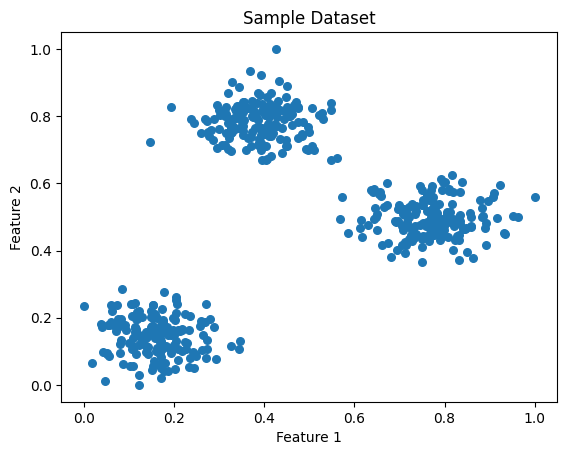

In [ ]:
# Generate 500 samples, 3 cluster centers, 2 features (for 2D visualisation)
X, y = make_blobs(
    n_samples=500,
    centers=3,
    cluster_std=1.4,
    #   c=y, cmap="viridis",
    n_features=2,
    random_state=42,
)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Visualise the dataset
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.title("Sample Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [3]:
X.describe()

,0,1
count,500.000000,500.000000
mean,0.439084,0.474316
std,0.261537,0.266973
min,0.000000,0.000000
25%,0.200622,0.187184
50%,0.393074,0.490092
75%,0.717048,0.744596
max,1.000000,1.000000


## 3. Selecting Optimal Parameters
To determine the optimal values for $\epsilon$ and $\text{min\_pts}$ for DBSCAN, we can use the **k-distance graph** (elbow method).

1. Choose $\text{min\_pts}$:
    - $\text{min\_pts} \geq \text{dimensions} + 1$ where $\text{dimensions}$ is the number of features.
    - For 2D data, start with $\text{min\_pts} = 4$.
    - For higher dimensions, $\text{min\_pts} = 2 \times \text{dimensions}$.
2. Compute k-distances:
    - For each data point, calculate the distance to its k-th nearest neighbour, where $k = \text{min\_pts}$.
    - Sort these distances in ascending order.
3. Plot the k-distance graph:
    - X-axis: Data points sorted by their k-distance.
    - Y-axis: k-distance values.
    - Identify the 'elbow' (point of maximum curvature) where distances sharply increase.
4. Set $\epsilon$:
    - $\epsilon$ = y-value at the elbow 

In [ ]:
def compute_k_distances(X: NDArray[np.float64], k: int) -> NDArray[np.float64]:
    """
    Compute distances to the k-th nearest neighbour for each point.

    Args:
        X: Input data, features.
        k: The neighbour's index to compute (k-th nearest neighbour)

    Returns:
        Array of distances to the k-th nearest neighbour for each point.
    """
    n = X.shape[0]
    k_distances = np.zeros(n)
    for i in range(n):
        # Calculate Euclidean distances from point i to all others
        distances = np.linalg.norm(X - X[i], axis=1)
        # Sort distances and select the k-th smallest (exclude self)
        sorted_dist = np.sort(distances)
        k_distances[i] = sorted_dist[k - 1]  # k-th neighbour (index k)
    return k_distances

In [ ]:
def find_optimal_params(X: pd.DataFrame) -> tuple[float, int]:
    """
    Determine optimal DBSCAN parameters using the k-distance elbow method.
    Also plot a k-distance graph.

    Args:
        X: Input data, features.

    Returns:
        A tuple that contains optimal epsilon and min_pts.
    """
    # Compute k-distances
    X = X.values
    dimensions = X.shape[1]
    min_pts = dimensions * 2
    k_distances = compute_k_distances(X, min_pts)
    sorted_k_distances = np.sort(k_distances)

    # Plot k-distance graph
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(sorted_k_distances)), sorted_k_distances, "b-")
    plt.xlabel("Points sorted by k-distance")
    plt.ylabel(f"Distance to {min_pts}-th nearest neighbor")
    plt.title("K-Distance Graph for Parameter Selection")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Find elbow point (heuristic: max curvature)
    slopes = np.diff(sorted_k_distances)
    drop = slopes[:-1] - slopes[1:]
    elbow_idx = np.argmax(drop) + 1  # +1 to adjust index
    epsilon = sorted_k_distances[elbow_idx]
    return epsilon, min_pts

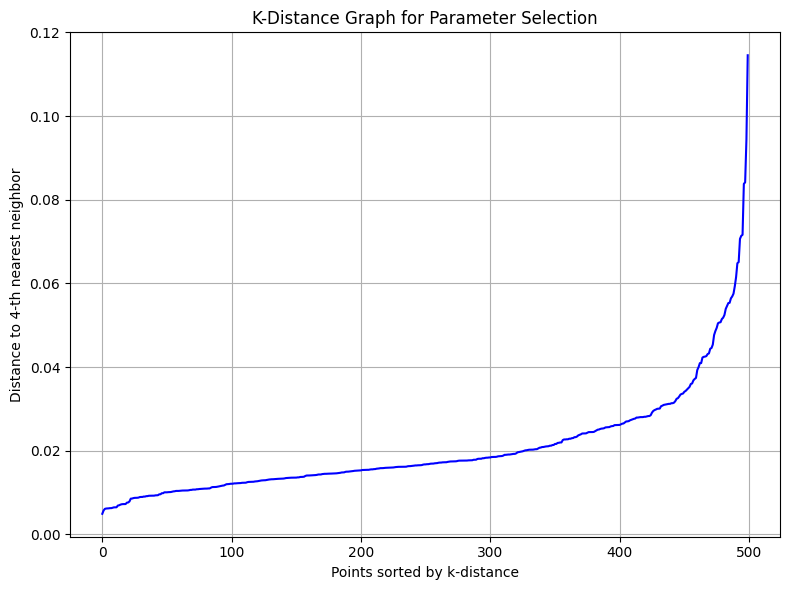

Optimal parameters: eps = 0.0838, min_pts = 4


In [6]:
epsilon, min_pts = find_optimal_params(X)
print(f"Optimal parameters: eps = {epsilon:.4f}, min_pts = {min_pts}")

## 4. Identifying Core Points
For each data point, we compute the Euclidean distance to count neighbours within the range $\epsilon$. Mark them as 'core' if the number of neighbours is $\geq \text{MinPts}$. Euclidean distance is calculated as:

\begin{align*}
\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
\end{align*}

In [ ]:
def find_neighbours(data: pd.DataFrame, point_idx: int, epsilon: float) -> list[int]:
    """
    Find neighbours within epsilon distance of a point.

    Args:
        data: Dataset as a NumPy array of shape (n_samples, n_features).
        point_idx: Index of the target point.
        epsilon: Neighbourhood radius.

    Returns:
        Indices of neighbours within epsilon distance.
    """
    data_np = data.values  # Convert to np.array
    distances = np.linalg.norm(data_np - data_np[point_idx], axis=1)  # Vectorised
    # Get indices where distance <= epsilon
    neighbours = np.where(distances <= epsilon)[0].tolist()
    return neighbours

A sample point (X.iloc[100]) has 74 neighbours.


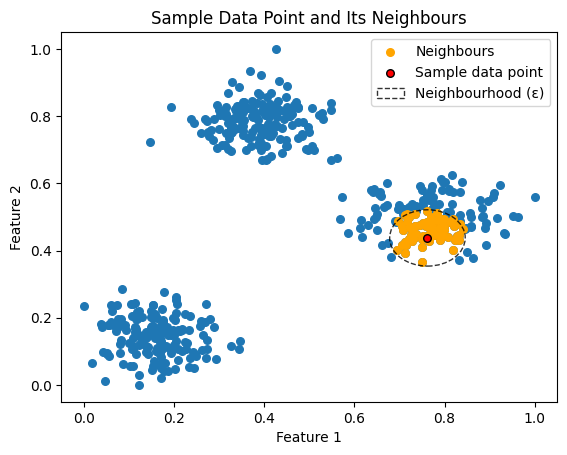

In [ ]:
test_point_idx = 100
test_neighbours = find_neighbours(X, [test_point_idx], epsilon)
print(
    f"A sample point (X.iloc[{test_point_idx}]) has {len(test_neighbours)} neighbours."
)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.scatter(
    X.iloc[test_neighbours, 0],
    X.iloc[test_neighbours, 1],
    s=30,
    c="orange",
    label="Neighbours",
)
plt.scatter(
    X.iloc[test_point_idx, 0],
    X.iloc[test_point_idx, 1],
    s=30,
    c="red",
    edgecolor="black",
    label="Sample data point",
)

circle = plt.Circle(
    (X.iloc[test_point_idx, 0], X.iloc[test_point_idx, 1]),
    radius=epsilon,
    color="black",
    fill=False,
    linestyle="--",
    alpha=0.8,
    label="Neighbourhood (ε)",
)
plt.gca().add_patch(circle)
plt.title("Sample Data Point and Its Neighbours")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## 5. Cluster Formation
We will expand clusters from core points using density reachability as follows:
1. Initialise cluster (starting point = `cluster_id`).
2. Iterate through the `neighbours` list.
3. Convert noise points to border points of the current cluster (noise should not have neighbours).
4. For unvisited points (`0`), assign to current cluster, check if it's a core point.
5. If core, dynamically extend the `neighbours` list with new points not already processed, enabling cluster expansion

In [ ]:
def expand_cluster(
    data: pd.DataFrame,
    labels: NDArray[np.int16],
    point_idx: int,
    neighbours: list[int],
    cluster_id: int,
    epsilon: float,
    min_pts: int,
) -> None:
    """
    Expand the cluster from a core point using density reachability.

    Args:
        data: Dataset as a DataFrame.
        labels: Array tracking point states (0=unvisited, -1=noise).
        point_idx: Index of the starting core point.
        neighbours: Initial neighbor indices.
        cluster_id: Current cluster ID to assign.
        epsilon: Neighbourhood radius.
        min_pts: Minimum number of points to form a core point.
    """
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbours):
        neighbor_idx = neighbours[i]
        if labels[neighbor_idx] == -1:  # Noise -> Border
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # Unvisited
            labels[neighbor_idx] = cluster_id
            new_neighbours = find_neighbours(data, neighbor_idx, epsilon)
            if len(new_neighbours) >= min_pts:  # Core point
                neighbours += [n for n in new_neighbours if n not in neighbours]
        i += 1

## 6. Prediction
In the following prediction function, `labels` tracks point states:
- $0$: Unvisited
- $-1$: Noise
- $>0$: Cluster ID (e.g., 1, 2, ...)

The `labels` is initialised with all $0$ s.

In [ ]:
def predict(data: pd.DataFrame, epsilon: float, min_pts: int) -> NDArray[np.int16]:
    """
    Performs DBSCAN clustering and returns cluster labels.

    Args:
        data (pd.DataFrame): Input data with shape (n_samples, n_features).
        epsilon: Neighbourhood radius..
        min_pts: Minimum number of points to form a core point.

    Returns:
        NDArray[np.int_]: Cluster labels (-1 for noise, >0 for cluster IDs).
    """
    n = len(data)
    labels = np.zeros(n)
    cluster_id = 0

    for i in tqdm(range(n)):
        if labels[i] != 0:
            continue

        neighbours = find_neighbours(data, i, epsilon)
        if len(neighbours) < min_pts:
            labels[i] = -1  # Mark as noise
        else:
            cluster_id += 1
            expand_cluster(data, labels, i, neighbours, cluster_id, epsilon, min_pts)
    return labels


predicted_labels = predict(X, epsilon, min_pts)
X["cluster_label"] = predicted_labels

100%|██████████| 500/500 [00:00<00:00, 4903.44it/s]


In [11]:
X.head()

,0,1,cluster_label
0,0.241332,0.097602,1.0
1,0.568619,0.493107,2.0
2,0.933597,0.450338,2.0
3,0.359366,0.698450,3.0
4,0.859761,0.473040,2.0


## 7. Visualisation

In [ ]:
def visualise_clusters(X: pd.DataFrame) -> None:
    """
    Visualise DBSCAN clustering results showing clusters and noise points.

    Args:
        X: DataFrame containing 'cluster_label' column and at least two features.
    """
    for label in sorted(X["cluster_label"].unique()):
        if label == -1:  # Noise points
            plt.scatter(
                X.loc[X["cluster_label"] == -1, X.columns[0]],
                X.loc[X["cluster_label"] == -1, X.columns[1]],
                s=30,
                c="black",
                label="Noise",
            )
        else:  # Cluster points
            plt.scatter(
                X.loc[X["cluster_label"] == label, X.columns[0]],
                X.loc[X["cluster_label"] == label, X.columns[1]],
                s=30,
                label=f"Cluster {label}",
            )

    plt.title("Clusters with Noise")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

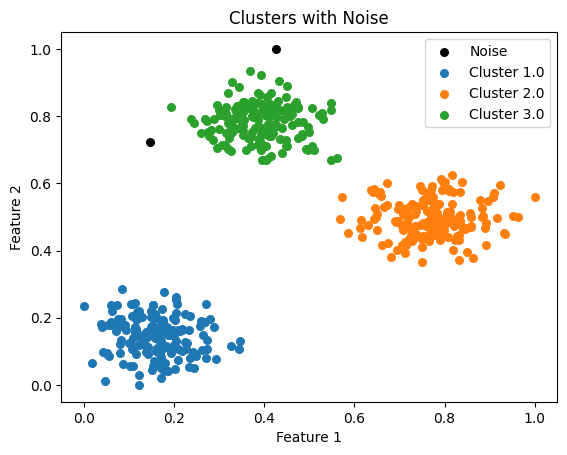

In [13]:
visualise_clusters(X)

## 8. Encapsulation

In [ ]:
class CustomDBSCAN:
    """
    Custom implementation of the DBSCAN clustering algorithm.

    Attributes:
        epsilon (float): The radius of the neighborhood around each point.
        min_pts (int): The minimum number of points required to form a dense region.
        labels_ (NDArray[np.int_]): Cluster labels for each point after fitting.
    """

    def __init__(self, epsilon: float, min_pts: int) -> None:
        """
        Initialise the DBSCAN object.

        Args:
            epsilon (float): Neighborhood radius.
            min_pts (int): Minimum number of points to form a core point.
        """
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.labels_ = None  # Cluster labels will be stored here after fitting

    def _find_neighbours(self, data: NDArray[np.float64], point_idx: int) -> list[int]:
        """
        Find neighbours within epsilon distance of a point.

        Args:
            data: Dataset as a NumPy array of shape (n_samples, n_features).
            point_idx: Index of the target point.

        Returns:
            Indices of neighbours within epsilon distance.
        """
        distances = np.linalg.norm(data - data[point_idx], axis=1)  # Vectorised
        # Get indices where distance <= epsilon
        return np.where(distances <= self.epsilon)[0].tolist()

    def _expand_cluster(
        self,
        data: NDArray[np.float64],
        labels: NDArray[np.int16],
        point_idx: int,
        neighbours: list[int],
        cluster_id: int,
    ) -> None:
        """
        Expand the cluster from a core point using density reachability.

        Args:
            data: Dataset as a NumPy array.
            labels: Array tracking point states (0=unvisited, -1=noise).
            point_idx: Index of the starting core point.
            neighbours: Initial neighbor indices.
            cluster_id: Current cluster ID to assign.
        """
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbours):
            neighbour_idx = neighbours[i]

            if labels[neighbour_idx] == -1:  # Noise -> Border
                labels[neighbour_idx] = cluster_id
            elif labels[neighbour_idx] == 0:  # Unvisited
                labels[neighbour_idx] = cluster_id
                new_neighbours = self._find_neighbours(data, neighbour_idx)
                if len(new_neighbours) >= self.min_pts:  # Core point
                    neighbours += [n for n in new_neighbours if n not in neighbours]
            i += 1

    def fit_predict(self, data: pd.DataFrame) -> NDArray[np.int16]:
        """
        Performs DBSCAN clustering and returns cluster labels.

        Args:
            data: Input data with shape (n_samples, n_features).

        Returns:
            NDArray[np.int16]: Cluster labels (-1 for noise, >0 for cluster IDs).
        """
        data_np = data.values
        n = len(data_np)
        labels = np.zeros(n, dtype=int)  # Initialise with all 0s.
        cluster_id = 0

        for i in tqdm(range(n), desc="Clustering"):
            if labels[i] != 0:  # Skip if already processed
                continue

            neighbours = self._find_neighbours(data_np, i)

            if len(neighbours) < self.min_pts:
                labels[i] = -1  # Mark as noise
            else:
                cluster_id += 1  # New cluster
                self._expand_cluster(data_np, labels, i, neighbours, cluster_id)
        self.labels_ = labels
        return labels

Clustering: 100%|██████████| 500/500 [00:00<00:00, 8928.72it/s]


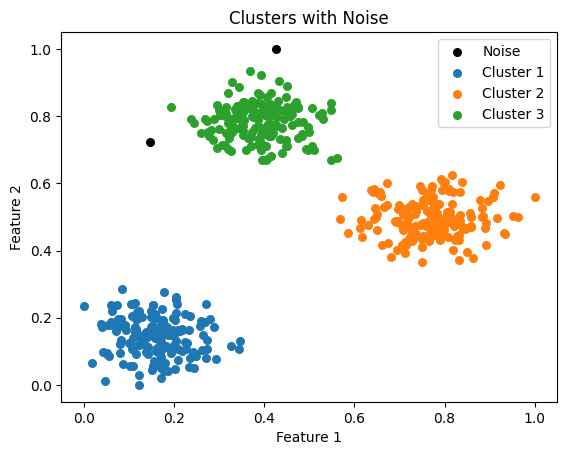

In [ ]:
# Initialise with parameters
dbscan = CustomDBSCAN(epsilon=epsilon, min_pts=min_pts)

# Perform clustering
labels = dbscan.fit_predict(X)

# Access results
X["cluster_label"] = labels  # Or dbscan.labels_
visualise_clusters(X)

## 9. Evaluation Metrics

### Silhouette Score
Silhouette score measures how well each data point fits within its cluster compared to other clusters. For each data point $i$, the silhouette values $s(i)$ quantifies two aspects:

- **Cohesion**: $a(i)$ - Cohesion is the average distance between $i$ and all other points in its cluster, indicating how close $i$ is to other points in the same cluster. Lower $a(i)$ means better cohesion.
- **Separation**: $b(i)$ - Separation is the minimum average distance between $i$ and points in any other cluster, demonstating how far $i$ is from points in the nearest different cluster. Higher $b(i)$ means better separation.

The silhouette score for point $i$ is then calculated as:
\begin{align*}
s(i) = \dfrac{b(i) - a(i)}{\text{max}(a(i), b(i))}
\end{align*}

The silouette score ranges from $-1$ to $+1$. Higer silhouette score indicates a better clustering result.
- Values close to $+1$ indicate that the point is well classified to its own cluster and poorly matched to neighbouring clusters (ideal).

- Values near $0$ indicate the point lies close to the boundary between two clusters.

- Values close to $-1$ suggest the point may be assigned to a wrong cluster (better fit elsewhere).

In [ ]:
def silhouette_score(X: NDArray[np.float64], labels: list[int]) -> np.float64:
    """
    Compute silhouette score for clustering results (excluding noise points).

    Args:
        X: Input data array.
        labels: Cluster labels (-1 indicates noise).

    Returns:
        Mean silhouette score for non-noise points, or NaN if < 2 valid clusters.
    """
    unique_labels = np.unique([label for label in labels if label != -1])  # without -1
    n_samples = len(X)
    silhouette_vals = np.zeros(n_samples)

    if len(unique_labels) < 2:
        return float("nan")  # Silhouette score undefined for < 2 clusters

    distance_matrix = np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=2)

    cluster_masks = {cluster: (labels == cluster) for cluster in unique_labels}

    for i in range(n_samples):
        if labels[i] == -1:
            silhouette_vals[i] = 0  # Noise points have 0 silhouette value
            continue

        own_cluster = labels[i]
        is_same_cluster = cluster_masks[own_cluster].copy()
        is_same_cluster[i] = False  # Excluding self

        # Calculate a_i
        if np.any(is_same_cluster):
            a_i = np.mean(distance_matrix[i, is_same_cluster])
        else:
            a_i = 0

        # Calculate b_i
        b_i = np.inf
        for cluster in unique_labels:
            if cluster == own_cluster:  # Skip own cluster
                continue
            other_mask = cluster_masks[cluster]
            if np.any(other_mask):
                distance = np.mean(distance_matrix[i, other_mask])
                if distance < b_i:
                    b_i = distance

        # Calculate silhouette for current point
        silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0

    valid_points = labels != -1
    if not np.any(valid_points):
        return float("nan")
    return np.mean(silhouette_vals[valid_points]).round(4)

### Noise Ratio and Cluster Count
The following `noise_ratio_and_cluster_count` is used to evaluate two important aspects of DBSCAN clustering results:
- **Noise Ratio**:
    Noise ratio is the proportion of points in the dataset that DBSCAN has labelled as noise (outliers). A higher noise ratio indicate that the DBSCAN parameters ($\epsilon$ and $\text{MinPts}$) are too strict, or that the data is very noisy. The noise ratio is calculated as:
    
\begin{align*}
\text{Noise Ratio} = \dfrac{\text{Number of points with label:$-1$}}{\text{Total number of points}}
\end{align*}

- **Number of Clusters**:
    DBSCAN automatically determines the number of clusters based on the density of the data. It is computed as the number of unique labels excluding the noise label ($-1$).


In [ ]:
def noise_ratio_and_cluster_count(labels: list[int]) -> tuple[float, int]:
    """
    Calculate noise ratio and cluster count for DBSCAN results.

    Args:
        labels: Cluster labels from DBSCAN (-1 = noise)

    Returns:
        Tuple containing:
        - noise_ratio: Proportion of noise points (0.0 to 1.0)
        - n_clusters: Number of clusters (excluding noise)
    """
    labels = np.array(labels)
    is_noise = labels == -1
    noise_ratio = float(np.mean(is_noise))

    unique_labels = np.unique([label for label in labels if label != -1])  # without -1
    n_clusters = len(unique_labels)
    return noise_ratio, n_clusters

In [ ]:
def evaluate(X: pd.DataFrame, labels: list[int]) -> dict[str, float | int]:
    """
    Evaluate DBSCAN clustering results using key metrics.

    Args:
        X: Input data DataFrame.
        labels: Cluster labels from DBSCAN.

    Returns:
        Dictionary containing:
        - silhouette_score: Mean silhouette score
        - noise_ratio: Proportion of noise points
        - n_clusters: Number of clusters
    """
    # Convert to NumPy array if DataFrame
    if not isinstance(X, np.ndarray):
        X = X.values
    silhouette = silhouette_score(X, labels)
    noise_ratio, n_clusters = noise_ratio_and_cluster_count(labels)
    return {
        "silhouette_score": silhouette,
        "noise_ratio": noise_ratio,
        "n_clusters": n_clusters,
    }

In [19]:
dbscan = CustomDBSCAN(epsilon=epsilon, min_pts=min_pts)
labels = dbscan.fit_predict(X)

# Evaluate
metrics = evaluate(X, labels)
print("Evaluation Metrics:")
print(f" - Silhouette Score (Custom): {metrics['silhouette_score']:.3f}")
print(f" - Noise Ratio (Custom): {metrics['noise_ratio']:.1%}")
print(f" - Clusters (Custom): {metrics['n_clusters']}")

Clustering: 100%|██████████| 500/500 [00:00<00:00, 15742.14it/s]

Evaluation Metrics:
 - Silhouette Score (Custom): 0.901
 - Noise Ratio (Custom): 0.4%
 - Clusters (Custom): 3


## 10. Comparison with Scikit-Learn

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN


sklearn_dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
sklearn_labels = sklearn_dbscan.fit_predict(X.values)
sklearn_noise_ratio, sk_learn_n_clusters = noise_ratio_and_cluster_count(sklearn_labels)
sil = silhouette_score(X, labels)

In [21]:
print("Evaluation Metrics:")
print(f" - Silhouette (SK): {sil:.4f}")
print(f" - Noise Ratio (Custom): {sklearn_noise_ratio:.1%}")
print(f" - Clusters (Custom): {sk_learn_n_clusters}")

Evaluation Metrics:
 - Silhouette (SK): 0.9009
 - Noise Ratio (Custom): 0.4%
 - Clusters (Custom): 3


## 11. References

1. Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996). [A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf). In Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226–231.

1. GeeksforGeeks. (2025). *DBSCAN Clustering in ML - Density based clustering*. <br>
https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/

1. Jakub Gotlib. (2022). *Presentation of dimensionality reduction techniques as the preparation for DBSCAN clustering*. <br>
https://rpubs.com/JGotlib/893092

1. Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). [DBSCAN revisited, revisited: why and how you should (still) use DBSCAN](https://doi.org/10.1145/3068335). ACM Transactions on Database Systems (TODS), 42(3), 19.

1. scikit-learn. (n.d.). *DBSCAN — scikit-learn Use Guide.* <br>
https://scikit-learn.org/stable/modules/clustering.html#dbscan

1. scikit-learn. (n.d.). *2.3.7. DBSCAN — scikit-learn API Reference.* <br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

1. StatQuest with Josh Starmer. (2022). *Clustering with DBSCAN, Clearly Explained!!!* [YouTube Video]. <br>
https://youtu.be/RDZUdRSDOok